# Data Preparation


## Importing Packages


In [1]:
import numpy as np
import nibabel as nib                                                     
#import itk                                                                
#import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate 
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
%matplotlib inline
import seaborn as sns

import os
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [19]:
import keras

In [2]:
import segmentation_models as sm
import tensorflow as tf
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from torch.utils.data import Dataset
from keras.models import load_model
from tensorflow.keras import utils as np_utils
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

Segmentation Models: using `keras` framework.


(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)


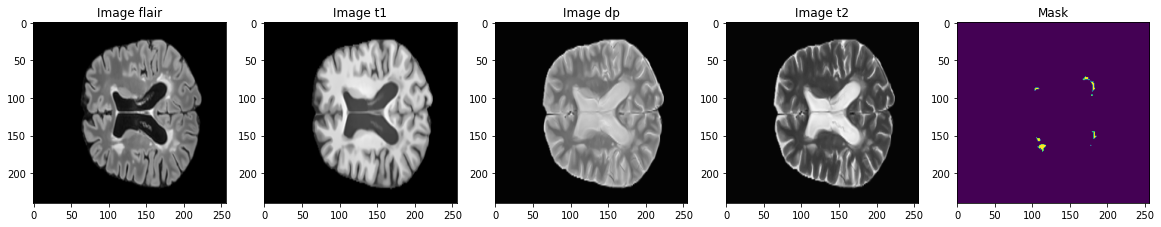

In [3]:
TRAIN_DATASET_PATH = 'D:/Projects/39111/Second_update/MSSEG2016_TrainingData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T1_preprocessed.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T2_preprocessed.nii').get_fdata()
test_image_dp=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_DP_preprocessed.nii').get_fdata()
test_image_Brain_Mask=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_Consensus.nii').get_fdata()
    

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w =280
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_dp[:,:,test_image_dp.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image dp')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_image_Brain_Mask[:,:,test_image_Brain_Mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

print(test_image_flair.shape)
print(test_image_t1.shape)
print(test_image_t2.shape)
print(test_image_dp.shape)
print(test_image_Brain_Mask.shape)

In [4]:
SEGMENT_CLASSES = {
    0 : 'NOT_MS',
    1 : 'MS' }


VOLUME_SLICES = 180 

VOLUME_START_AT =300

total count: 3943435


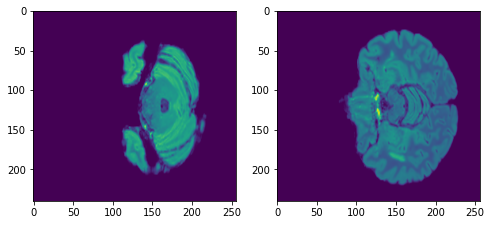

In [5]:
VOLUME_START_AT=260
VOLUME_SLICES=250

def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 10))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

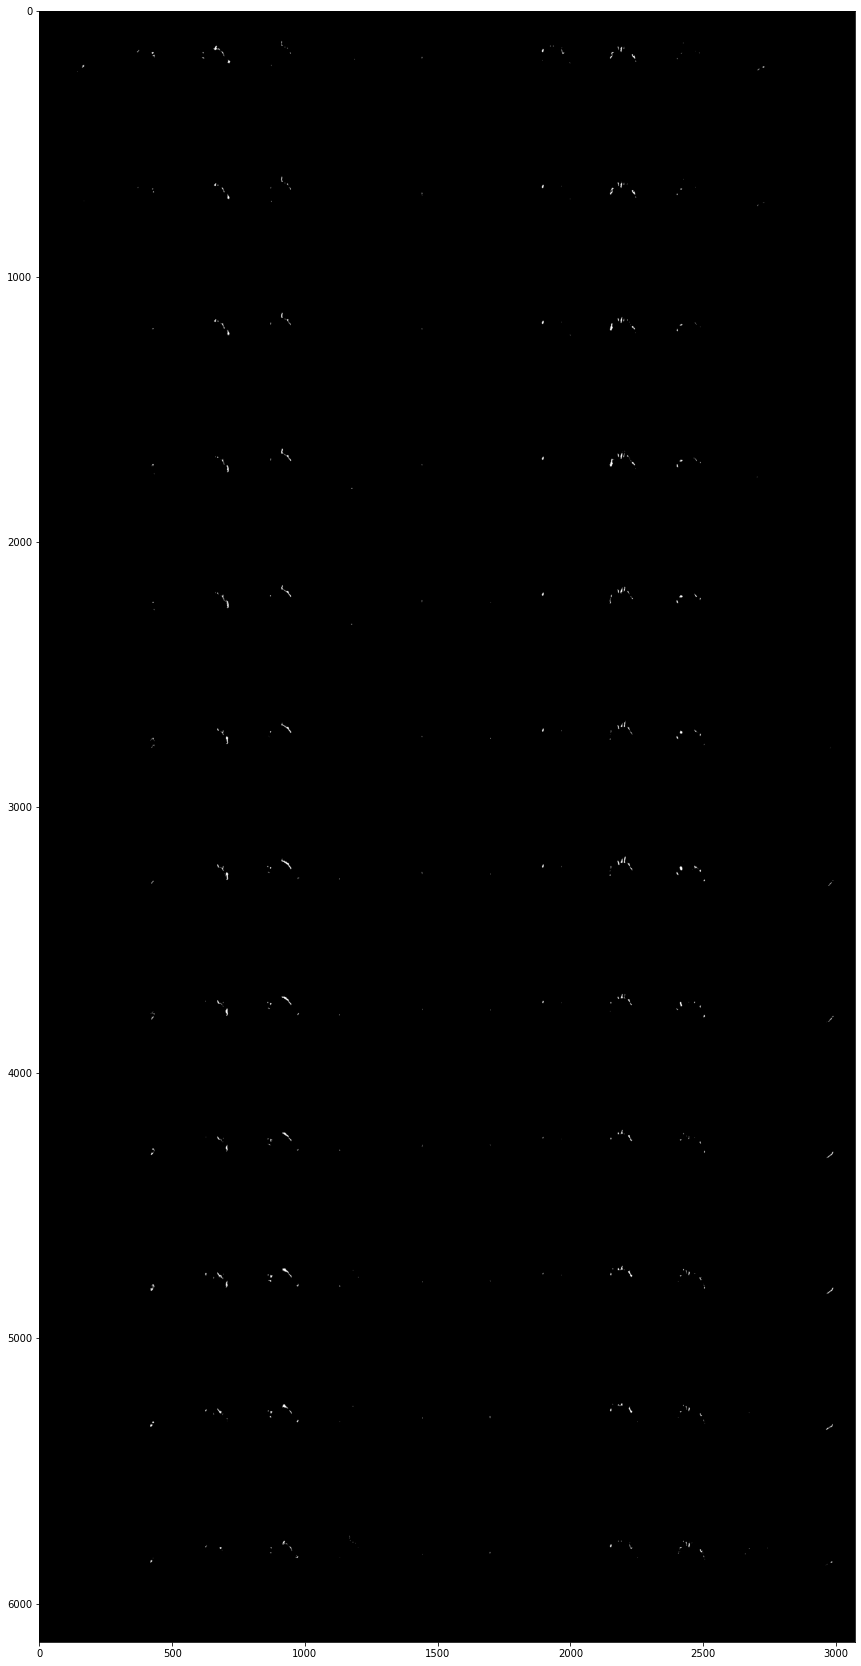

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,30))
ax1.imshow(rotate(montage(test_image_Brain_Mask[50:-50,:,:]), 90, resize=True), cmap ='gray')

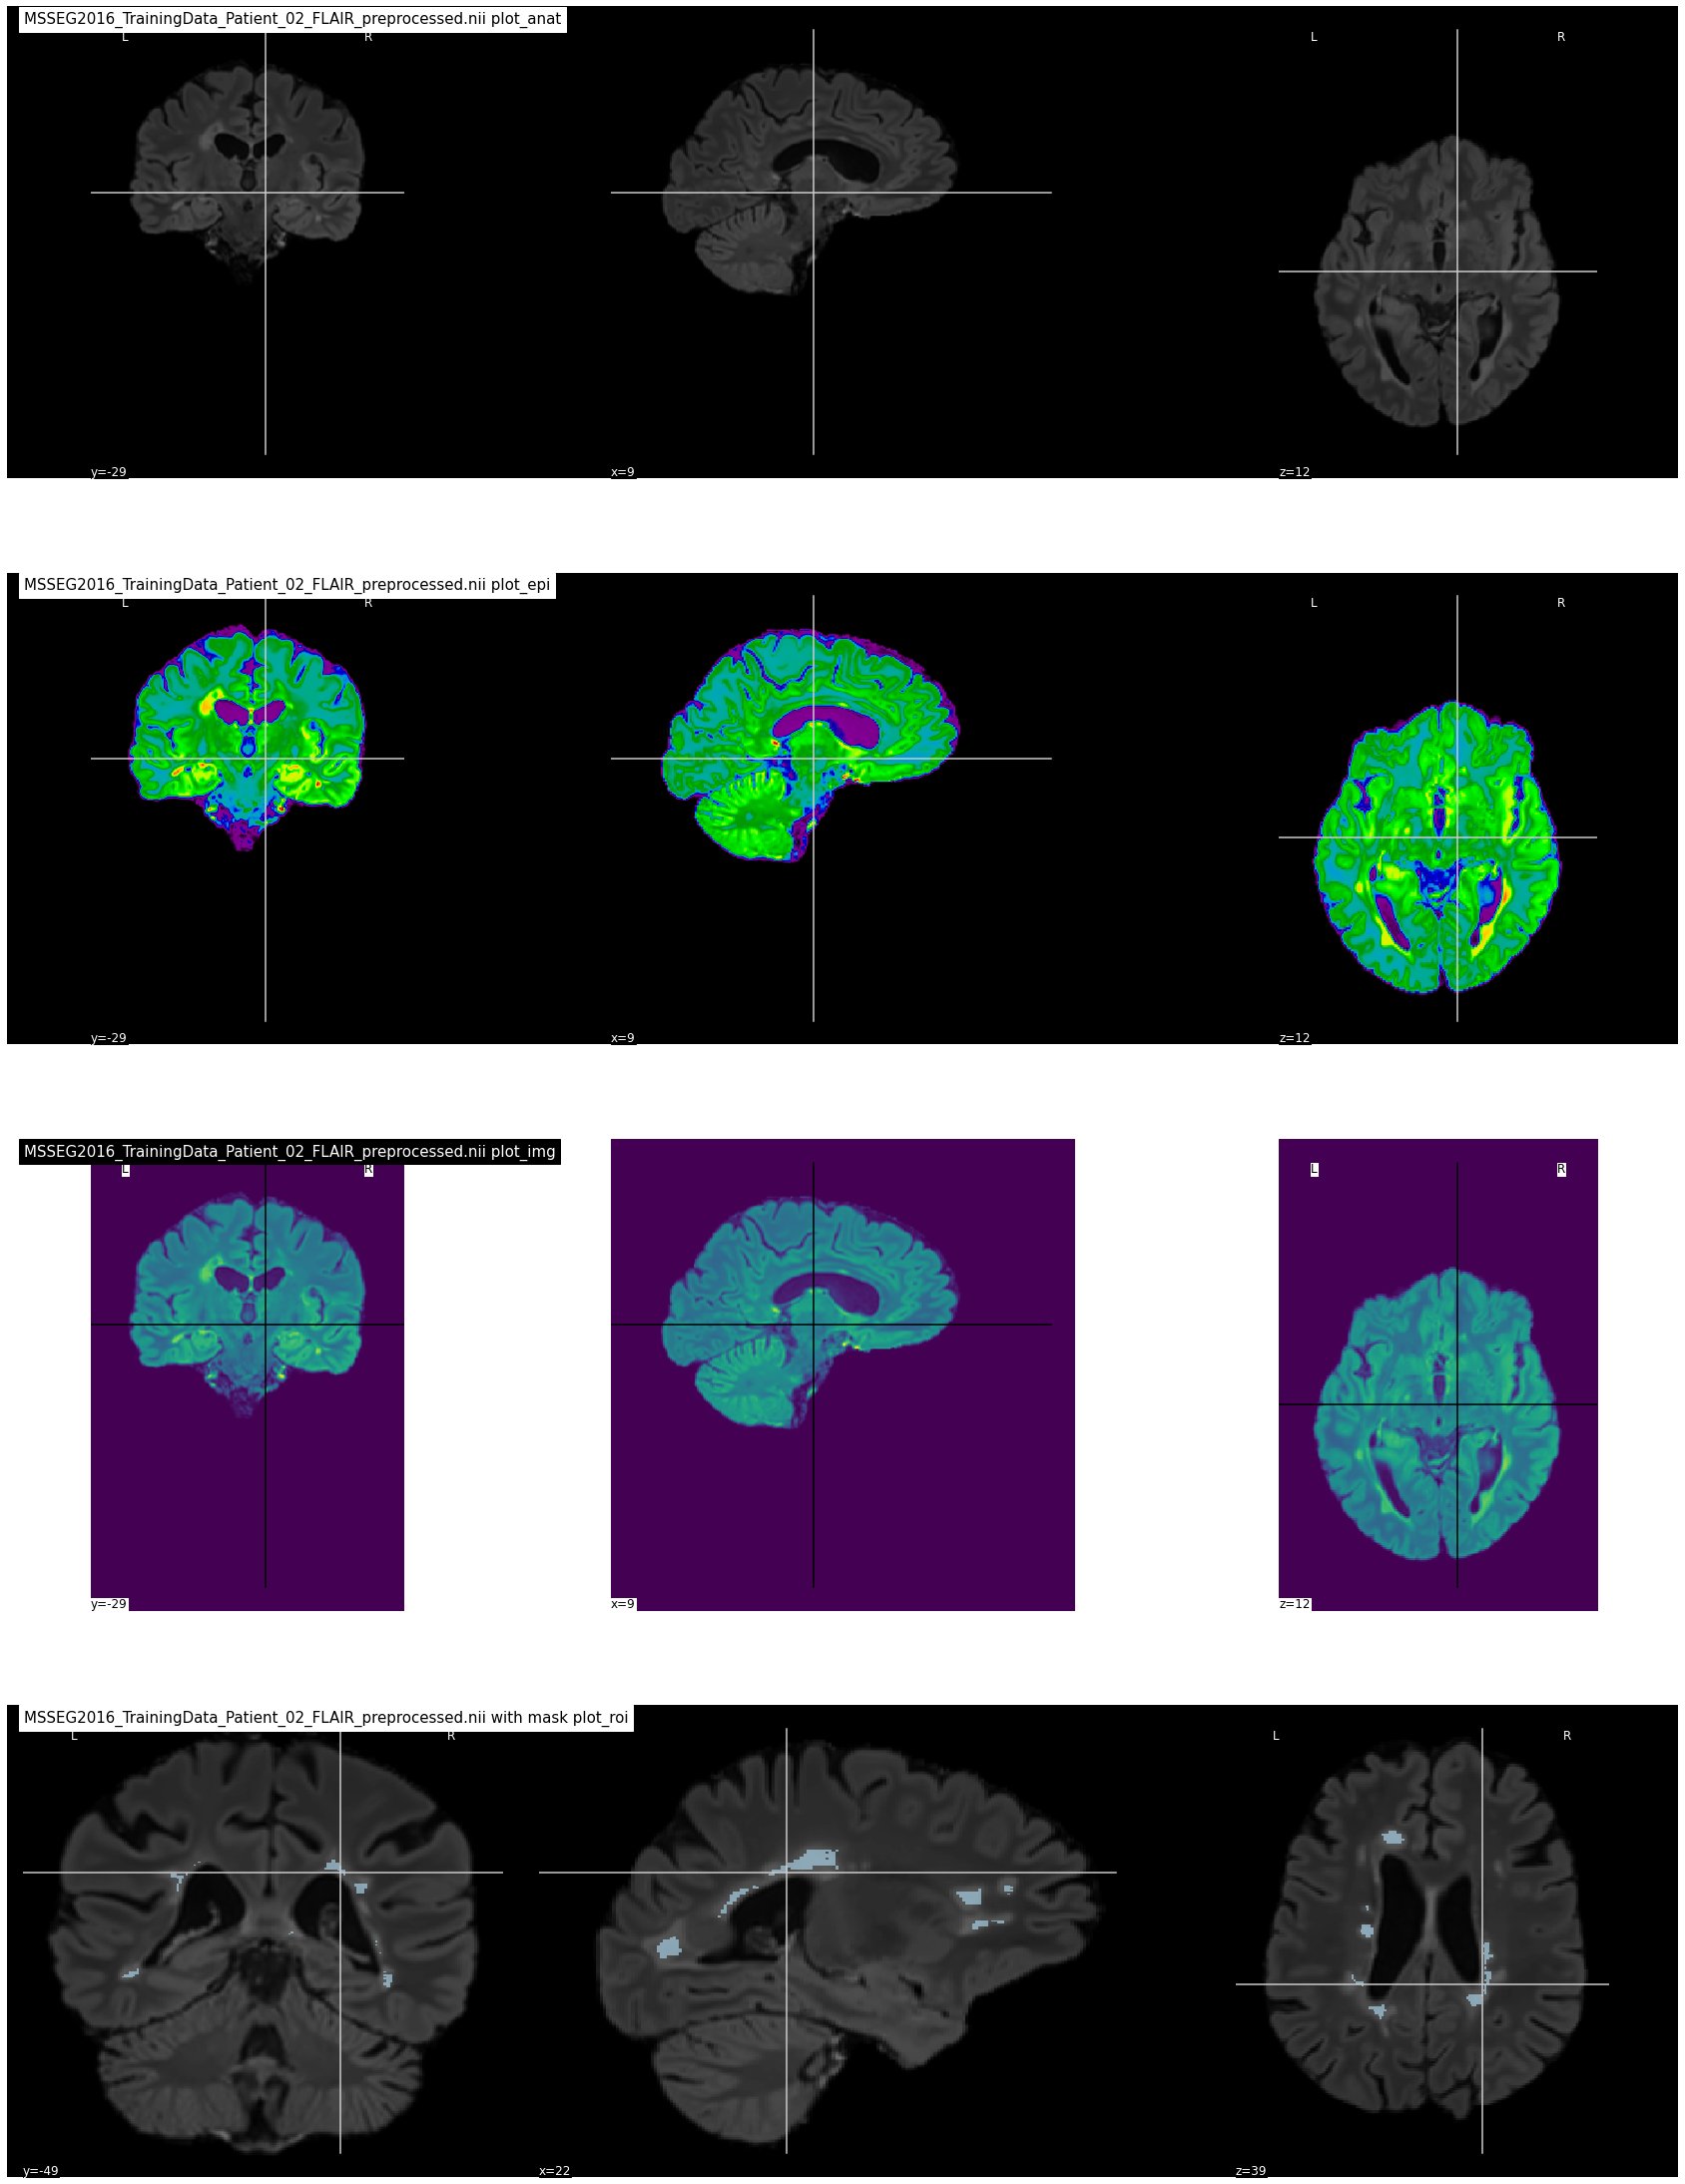

In [7]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_Consensus.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

Dice Loss. The Dice coefficient is widely used metric in computer vision community to calculate the similarity between two images

Dice Loss is widely used in medical image segmentation tasks to address the data imbalance problem. However, it only addresses the imbalance problem between foreground and background yet overlooks another imbalance between easy and hard examples that also severely affects the training process of a learning model.

Loss function :

Dice coefficient , which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

The Dice coefficient is very similar to the IoU. They are positively correlated, meaning if one says model A is better than model B at segmenting an image, then the other will say the same. Like the IoU, they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

In [6]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

def dice_coef_MS(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [8]:
IMG_SIZE=128

Loading all data into memory is not a good idea since the data are too big to fit in. So we will create dataGenerators - load data on the fly.

Prepare image paths to feed DataGenerator function

In [10]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size =1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
                
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 256))
        
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 2))
        
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_FLAIR_preprocessed.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_DP_preprocessed.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_Consensus.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
            
        # Generate masks
        y[y==0] = 0;
        
        mask = tf.one_hot(y, 2);
        
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
    

        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


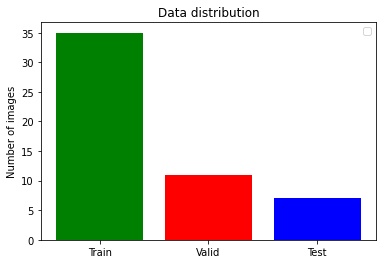

In [11]:
# show number of data for each dir 

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

## Existing Model # 1

## UNET Model

In [12]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(256,1,2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    conv7 = concatenate([conv7,conv71], axis = 3)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(128,1,2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv81)
    conv8 = concatenate([conv8,conv81], axis = 3)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(64,1,2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv91)
    conv9 = concatenate([conv9,conv91], axis = 3)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(32,1,2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    conv = concatenate([conv,conv1], axis = 3)
    
    conv10 = Conv2D(2, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)


In [13]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.2 ), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  608         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 spose)                                                                                           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 64)   65600       ['up_sampling2d_2[0][0]']        
                                                                                                  
 conv2d_25 (Conv2D)             (None, 64, 64, 64)   16448       ['conv2d_transpose_2[0][0]']     
                                                                                                  
 concatenate_6 (Concatenate)    (None, 64, 64, 128)  0           ['conv2d_3[0][0]',               
                                                                  'conv2d_22[0][0]']              
                                                                                                  
 concatenate_7 (Concatenate)    (None, 64, 64, 128)  0           ['conv2d_3[0][0]',               
          

In [14]:
from keras.callbacks import CSVLogger

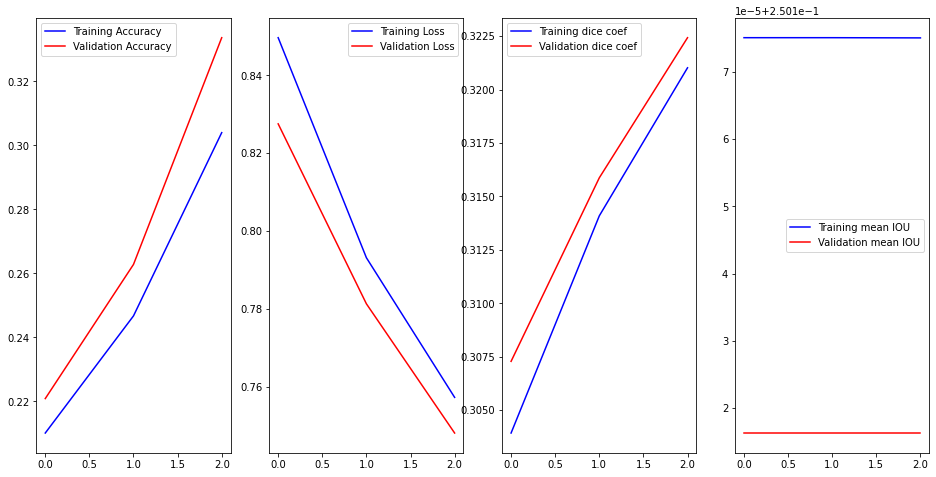

In [15]:
import pandas as pd
############ load trained model ################

model = keras.models.load_model('Unet.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)

history = pd.read_csv('UNET.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [18]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.2), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
U_net= model.evaluate(test_generator)
print("test loss, test acc:", U_net)

Evaluate on test data
7/7 [==============================] - 128s 18s/step - loss: 0.7380 - accuracy: 0.3959 - mean_io_u_2: 0.2501 - dice_coef: 0.3244 - precision: 0.3958 - sensitivity: 0.3958 - specificity: 0.3958
test loss, test acc: [0.7379701733589172, 0.395870566368103, 0.2500815689563751, 0.3243771195411682, 0.3957999646663666, 0.39583081007003784, 0.3958303928375244]


## Existing Model # 2

# Resnet

In [18]:
BACKBONE = 'resnet50'

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 2 
activation = 'softmax'

#create model
model_resnet = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True, input_shape = (128,128,2))


# compile keras model with defined optimozer, loss and metrics
model_resnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,precision, sensitivity, specificity] )

In [19]:
model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 2)  6           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 2)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   6272        ['zero_padding2d[0][0]']   

 stage1_unit3_bn1 (BatchNormali  (None, 32, 32, 256)  1024       ['add_1[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, 32, 32, 256)  0          ['stage1_unit3_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 32, 32, 64)   16384       ['stage1_unit3_relu1[0][0]']     
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 32, 32, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
          

                                                                                                  
 stage2_unit2_relu3 (Activation  (None, 16, 16, 128)  0          ['stage2_unit2_bn3[0][0]']       
 )                                                                                                
                                                                                                  
 stage2_unit2_conv3 (Conv2D)    (None, 16, 16, 512)  65536       ['stage2_unit2_relu3[0][0]']     
                                                                                                  
 add_4 (Add)                    (None, 16, 16, 512)  0           ['stage2_unit2_conv3[0][0]',     
                                                                  'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, 16, 16, 512)  2048       ['add_4[0][0]']                  
 zation)  

 zero_padding2d_9 (ZeroPadding2  (None, 18, 18, 256)  0          ['stage3_unit1_relu2[0][0]']     
 D)                                                                                               
                                                                                                  
 stage3_unit1_conv2 (Conv2D)    (None, 8, 8, 256)    589824      ['zero_padding2d_9[0][0]']       
                                                                                                  
 stage3_unit1_bn3 (BatchNormali  (None, 8, 8, 256)   1024        ['stage3_unit1_conv2[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage3_unit1_relu3 (Activation  (None, 8, 8, 256)   0           ['stage3_unit1_bn3[0][0]']       
 )                                                                                                
          

                                                                                                  
 stage3_unit4_conv1 (Conv2D)    (None, 8, 8, 256)    262144      ['stage3_unit4_relu1[0][0]']     
                                                                                                  
 stage3_unit4_bn2 (BatchNormali  (None, 8, 8, 256)   1024        ['stage3_unit4_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage3_unit4_relu2 (Activation  (None, 8, 8, 256)   0           ['stage3_unit4_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 10, 10, 256)  0          ['stage3_unit4_relu2[0][0]']     
 2D)      

                                                                  'add_11[0][0]']                 
                                                                                                  
 stage4_unit1_bn1 (BatchNormali  (None, 8, 8, 1024)  4096        ['add_12[0][0]']                 
 zation)                                                                                          
                                                                                                  
 stage4_unit1_relu1 (Activation  (None, 8, 8, 1024)  0           ['stage4_unit1_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 stage4_unit1_conv1 (Conv2D)    (None, 8, 8, 512)    524288      ['stage4_unit1_relu1[0][0]']     
                                                                                                  
 stage4_un

 stage4_unit3_bn3 (BatchNormali  (None, 4, 4, 512)   2048        ['stage4_unit3_conv2[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu3 (Activation  (None, 4, 4, 512)   0           ['stage4_unit3_bn3[0][0]']       
 )                                                                                                
                                                                                                  
 stage4_unit3_conv3 (Conv2D)    (None, 4, 4, 2048)   1048576     ['stage4_unit3_relu3[0][0]']     
                                                                                                  
 add_15 (Add)                   (None, 4, 4, 2048)   0           ['stage4_unit3_conv3[0][0]',     
                                                                  'add_14[0][0]']                 
          

                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 64, 64, 64)  0           ['decoder_stage2b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_stage3_concat (Concate  (None, 64, 64, 128)  0          ['decoder_stage3_upsampling[0][0]
 nate)                                                           ',                               
                                                                  'relu0[0][0]']                  
                                                                                                  
 decoder_stage3a_conv (Conv2D)  (None, 64, 64, 32)   36864       ['decoder_stage3_concat[0][0]']  
                                                                                                  
 decoder_s

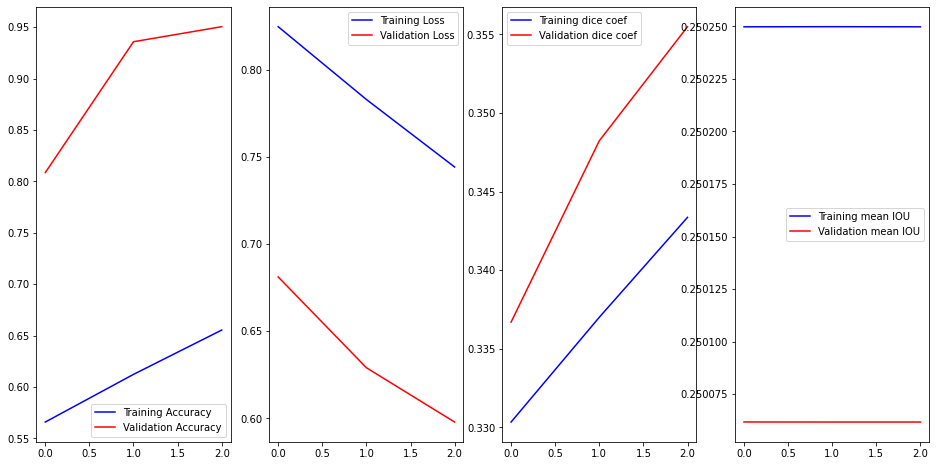

In [20]:
import pandas as pd
############ load trained model ################
model = keras.models.load_model('Resnet.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)

history = pd.read_csv('RESNET.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_3'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_3'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [21]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet = model.evaluate(test_generator)
print("test loss, test acc:", resnet)

Evaluate on test data
7/7 [==============================] - 77s 11s/step - loss: 0.5990 - accuracy: 0.9446 - mean_io_u_5: 0.2503 - dice_coef: 0.3566 - dice_coef_MS: 0.0079 - precision: 0.9439 - sensitivity: 0.9442 - specificity: 0.9442
test loss, test acc: [0.5989692211151123, 0.9446286559104919, 0.2502952814102173, 0.35663872957229614, 0.007860073819756508, 0.9439080953598022, 0.9441954493522644, 0.9441954493522644]


## Existing Model # 3

# Inceptionv3_net

In [22]:
def inceptionv3_unet():
    
    BACKBONE = 'inceptionv3'
    
    preprocess_input = sm.get_preprocessing(BACKBONE)
    
    n_classes = 2
    
    activation = 'softmax'
    
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    
    return model

model_inceptionv3 = inceptionv3_unet()

model_inceptionv3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, precision, sensitivity, specificity] )

model_inceptionv3.summary()

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_applications\imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 64, 64, 32)   576         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  96          ['conv2d_35[0][0]']              
 alization)                                                                                       
                                                                                            

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_55 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_69 (Conv2D)             (None, 8, 8, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 8, 8, 128)   384         ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 8, 8, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 8, 8, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 8, 8, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 8, 8, 160)   480         ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 8, 8, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_76

 batch_normalization_55 (BatchN  (None, 8, 8, 160)   480         ['conv2d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 8, 8, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 8, 8, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_91 (Conv2D)             (None, 8, 8, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 8, 8, 160)   480         ['conv2d_86[0][0]']              
 ormalizat

 conv2d_96 (Conv2D)             (None, 8, 8, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_101 (Conv2D)            (None, 8, 8, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 8, 8, 192)   576         ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 8, 8, 192)   576         ['conv2d_101[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 8, 8, 192)   576         ['conv2d_109[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 8, 8, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 8, 8, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_106 (Conv2D)            (None, 4, 4, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 4, 4, 192)   576         ['conv2d_119[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 4, 4, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 4, 4, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 4, 4, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_13 (Concatenate)   (None, 4, 4, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

 decoder_stage2b_relu (Activati  (None, 32, 32, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 64, 64, 64)  0           ['decoder_stage2b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_stage3_concat (Concate  (None, 64, 64, 128)  0          ['decoder_stage3_upsampling[0][0]
 nate)                                                           ',                               
                                                                  'activation_2[0][0]']           
                                                                                                  
 decoder_s

In [23]:
import pandas as pd
############ load trained model ################
model1 = keras.models.load_model('inceptionv3.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)


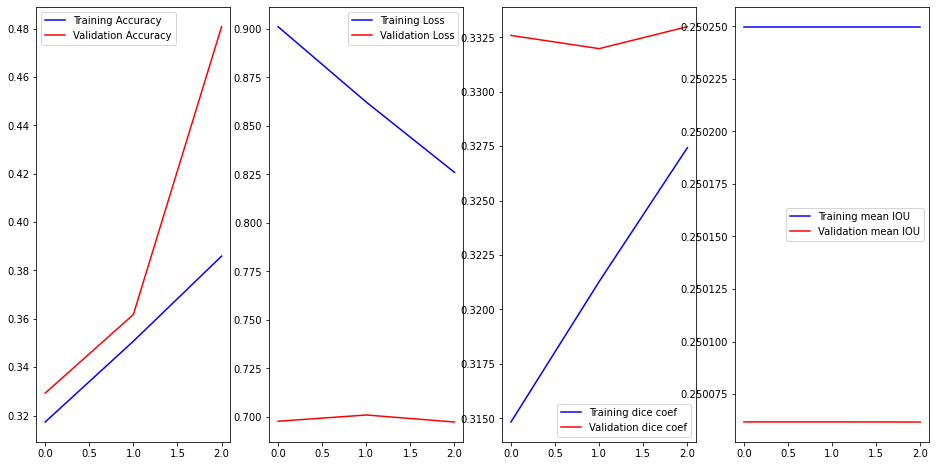

In [24]:
history = pd.read_csv('inceptionv3.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_13'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_13'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [25]:
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
inceptionv3 = model1.evaluate(test_generator)
print("test loss, test acc:", inceptionv3)

Evaluate on test data
7/7 [==============================] - 61s 8s/step - loss: 0.6968 - accuracy: 0.4831 - mean_io_u_8: 0.2503 - dice_coef: 0.3345 - dice_coef_MS: 0.0072 - precision: 0.4827 - sensitivity: 0.4828 - specificity: 0.4828
test loss, test acc: [0.696842610836029, 0.4831056296825409, 0.2502952814102173, 0.3344569802284241, 0.007199686020612717, 0.48266884684562683, 0.4828164875507355, 0.48281624913215637]


# Proposed Model

# Dual Vnet

In [26]:
def dualvnet_architecture():

    inputs = Input(shape=(128, 128, 2), name='input')
    convolution1 = Conv2D(
            32, 3, padding='same', activation='relu')(inputs)
    normalization1 = BatchNormalization()(convolution1)

    convolution2 = Conv2D(
            32, 3, padding='same', activation='relu')(normalization1 )
    normalization2 = BatchNormalization()(convolution2 )

    pool = MaxPooling2D()(normalization2)


    convolution11 = Conv2D(
            64, 3, padding='same', activation='relu')(pool)
    normalization11 = BatchNormalization()(convolution11)

    convolution12 = Conv2D(
           64, 3, padding='same', activation='relu')(normalization11)
    normalization12 = BatchNormalization()(convolution12)

    pool1 = MaxPooling2D()(normalization12)



    convolution21 = Conv2D(
            128, 3, padding='same', activation='relu')(pool1)
    normalization21 = BatchNormalization()(convolution21)

    convolution22 = Conv2D(
            128, 3, padding='same', activation='relu')(normalization21)
    normalization22 = BatchNormalization()(convolution22 )

    pool2 = MaxPooling2D()(normalization22)

    dropout_1 = Dropout(0.2)(pool2)


    convolution31 = Conv2D(256, 3, padding='same', activation='relu',
                                  )(dropout_1)
    normalization31 = BatchNormalization()(convolution31 )

    convolution32 = Conv2D(256, 3, padding='same',
                                  activation='relu')(normalization31)
    normalization32 = BatchNormalization()(convolution32)

    pool3 = MaxPooling2D()(normalization32)


    convolution41 = Conv2D(512, 3, padding='same', activation='relu')(pool3)
    
    normalization41 = BatchNormalization()(convolution41)

    convolution42 = Conv2D(512, 3, padding='same',
                                  activation='relu')(normalization41)
    normalization42 = BatchNormalization()(convolution42)

    pool4 = MaxPooling2D()(normalization42)


    convolution51 = Conv2D(
            1024, 3, padding='same', activation='relu')(pool4)



    upscaling_1 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(convolution51)

    merged1 = Add()(
            [normalization41 , normalization42, upscaling_1])

    dconvolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged1)

    upscaling_2 = Conv2DTranspose(256, 3, strides=(
           2, 2), padding='same', activation='relu')(dconvolution1 )

    merged2 = Add()(
            [normalization31 , normalization32, upscaling_2])

    dconvolution21 = Conv2D(
           256, 3, padding='same', activation='relu')(merged2)

    dropout_2 = Dropout(0.2)(dconvolution21)


    upscaling_3 = Conv2DTranspose(128, 3, strides=(
            2, 2), padding='same', activation='relu')(dropout_2)


    merged3 = Add()(
           [normalization21, normalization22, upscaling_3])

    dconvolution31 = Conv2D(
           128, 3, padding='same', activation='relu')(merged3)

    upscaling_4 = Conv2DTranspose(64, 3, strides=(
          2, 2), padding='same', activation='relu')(dconvolution31)

    merged4 = Add()(
           [normalization11, normalization12, upscaling_4])

    dconvolution41 = Conv2D(
           64, 3, padding='same', activation='relu')(merged4)

    upscaling_5 = Conv2DTranspose(32, 3, strides=(
           2, 2), padding='same', activation='relu')(dconvolution41 )

    merged5 = Add()(
           [normalization1,normalization2, upscaling_5])

    dconvolution51 = Conv2D(
            32, 3, padding='same', activation='relu')(merged5)


    convolution61 = Conv2D(32, 3, padding='same', activation='relu')(dconvolution51)
    normalization61 = BatchNormalization()(convolution61)

    convolution62 = Conv2D(32, 3, padding='same',
                                  activation='relu')(normalization61)
    normalization62 = BatchNormalization()(convolution62)
    pool6 = MaxPooling2D()(normalization62)


    convolution71 = Conv2D(64, 3, padding='same',
                                  activation='relu')(pool6)
    normalization71 = BatchNormalization()(convolution71)
    convolution72 = Conv2D(64, 3, padding='same',
                                  activation='relu')(normalization71)
    normalization72 = BatchNormalization()(convolution72)
    pool7 = MaxPooling2D()(normalization72)


    convolution81 = Conv2D(128, 3, padding='same',
                                  activation='relu')(pool7)
    normalization81 = BatchNormalization()(convolution81)
    convolution82 = Conv2D(128, 3, padding='same',
                                  activation='relu')(normalization81 )
    normalization82 = BatchNormalization()(convolution82)
    pool8 = MaxPooling2D()(normalization82)

    edropout_2 = Dropout(0.2)(pool8)


    convolution91 = Conv2D(
            256, 3, padding='same', activation='relu')(edropout_2)
    normalization91 = BatchNormalization()(convolution91)
    convolution92 = Conv2D(256, 3, padding='same',
                                  activation='relu')(normalization91)
    normalization92 = BatchNormalization()(convolution92 )
    pool9 = MaxPooling2D()(normalization92 )

    convolution101 = Conv2D(512, 3, padding='same',
                                   activation='relu')(pool9)
    normalization101 = BatchNormalization()(convolution101)
    convolution102 = Conv2D(
            512, 3, padding='same', activation='relu')(normalization101)
    normalization102 = BatchNormalization()(convolution102)
    pool10 = MaxPooling2D()(normalization102)

    convolution111 = Conv2D(1024, 3, padding='same',
                                   activation='relu')(pool10)
    

    upscaling_6 = Conv2DTranspose(512, 3, strides=(
           2, 2), padding='same', activation='relu')(convolution111)
    merged6 = Add()(
           [normalization101, normalization102, upscaling_6])
    dconvolution61 = Conv2D(
           512, 3, padding='same', activation='relu')(merged6)
    upscaling_7 = Conv2DTranspose(256, 3, strides=(
            2, 2), padding='same', activation='relu')(dconvolution61)
    merged7 = Add()(
            [normalization91, normalization92, upscaling_7])
    dconvolution71 = Conv2D(
            256, 3, padding='same', activation='relu')(merged7)
    ddropout_2 = Dropout(
            0.2)(dconvolution71)
    upscaling_8 = Conv2DTranspose(128, 3, strides=(
          2, 2), padding='same', activation='relu')(ddropout_2)
    merged8 = Add()(
           [normalization81 , normalization82, upscaling_8])
    dconvolution81 = Conv2D(
          128, 3, padding='same', activation='relu')(merged8)
    upscaling_9 = Conv2DTranspose(64, 3, strides=(
            2, 2), padding='same', activation='relu')(dconvolution81)
    merged9 = Add()(
           [normalization71, normalization72, upscaling_9])
    dconvolution91 = Conv2D(
           64, 3, padding='same', activation='relu')(merged9)
    upscaling_10 = Conv2DTranspose(32, 3, strides=(
            2, 2), padding='same', activation='relu')(dconvolution91)
    merged10 = Add()(
            [normalization61,normalization62, upscaling_10])
    dconvolution101 = Conv2D(
           32, 3, padding='same', activation='relu')(merged10)
    pre_output = Conv2D(32, 1, padding='same', activation='relu')(
           dconvolution101)

    output = Conv2D(2, 1, padding='same', activation='softmax',
                    name='output')(pre_output)

    model = Model(inputs=inputs, outputs=output)

    return model



model_dualvnet = dualvnet_architecture()


model_dualvnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )

model_dualvnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_129 (Conv2D)            (None, 128, 128, 32  608         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 128, 128, 32  128        ['conv2d_129[0][0]']             
 ormalization)                  )                                                           

                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (None, 16, 16, 256)  1179904    ['conv2d_140[0][0]']             
 spose)                                                                                           
                                                                                                  
 add_17 (Add)                   (None, 16, 16, 256)  0           ['batch_normalization_100[0][0]',
                                                                  'batch_normalization_101[0][0]',
                                                                  'conv2d_transpose_5[0][0]']     
                                                                                                  
 conv2d_141 (Conv2D)            (None, 16, 16, 256)  590080      ['add_17[0][0]']                 
                                                                                                  
 dropout_2

 conv2d_151 (Conv2D)            (None, 16, 16, 256)  295168      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_110 (Batch  (None, 16, 16, 256)  1024       ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_152 (Conv2D)            (None, 16, 16, 256)  590080      ['batch_normalization_110[0][0]']
                                                                                                  
 batch_normalization_111 (Batch  (None, 16, 16, 256)  1024       ['conv2d_152[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 max_pooli

__________________________________________________________________________________________________


In [27]:
import pandas as pd
############ load trained model ################
model1 = keras.models.load_model('Dualvnet.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)


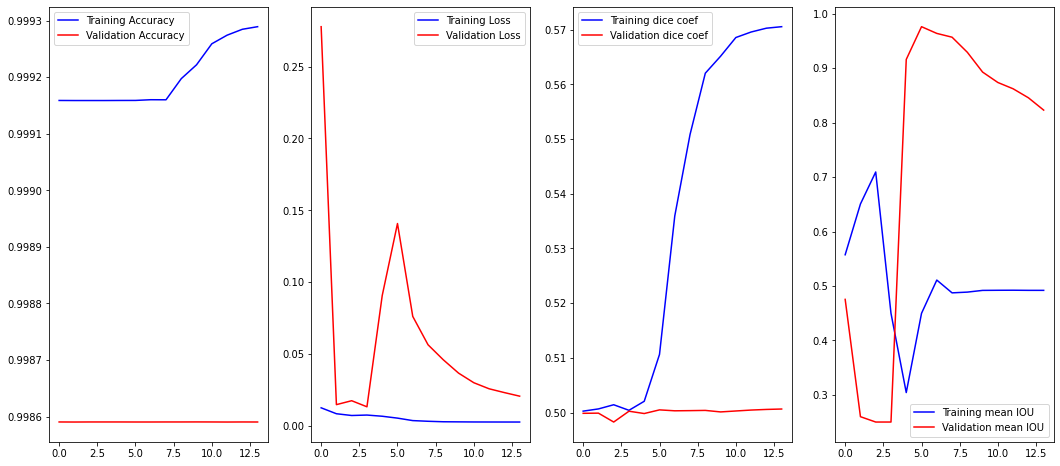

In [28]:
history = pd.read_csv('Dualvnet.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(18,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [29]:
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
dualvnet = model1.evaluate(test_generator)
print("test loss, test acc:", dualvnet)

Evaluate on test data
7/7 [==============================] - 198s 29s/step - loss: 0.0160 - accuracy: 0.9984 - mean_io_u_11: 0.8291 - dice_coef: 0.5018 - precision: 0.9981 - sensitivity: 0.9984 - specificity: 0.9984
test loss, test acc: [0.016011472791433334, 0.9984412789344788, 0.82908695936203, 0.5018028020858765, 0.9981362223625183, 0.9984400868415833, 0.9984400868415833]


11/11 [==============================] - 44s 4s/step


<Figure size 720x1080 with 0 Axes>

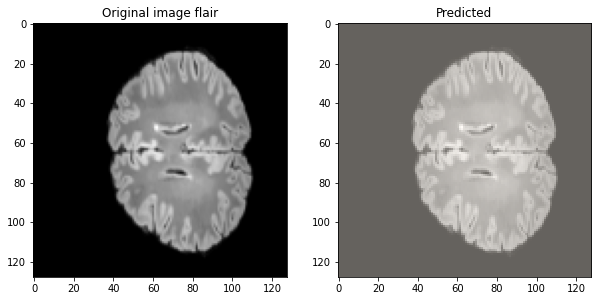

11/11 [==============================] - 41s 4s/step


<Figure size 720x1080 with 0 Axes>

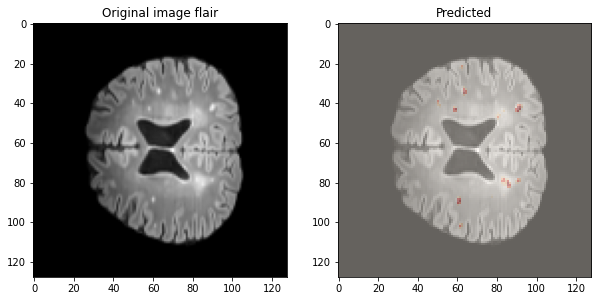

11/11 [==============================] - 39s 4s/step


<Figure size 720x1080 with 0 Axes>

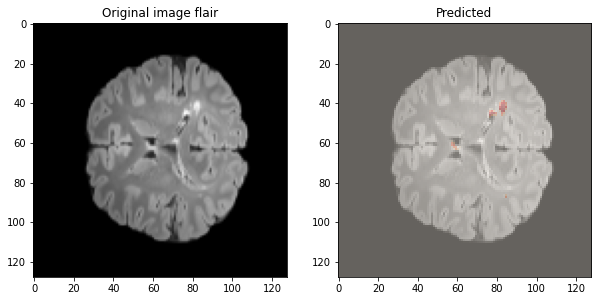

11/11 [==============================] - 39s 3s/step


<Figure size 720x1080 with 0 Axes>

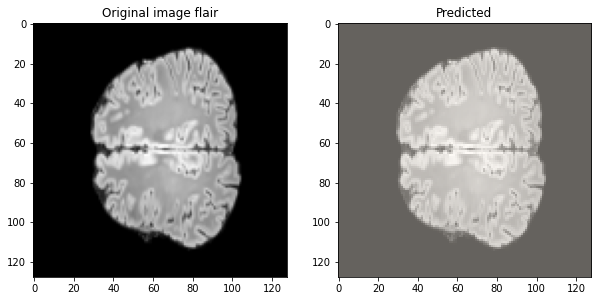

11/11 [==============================] - 40s 4s/step


<Figure size 720x1080 with 0 Axes>

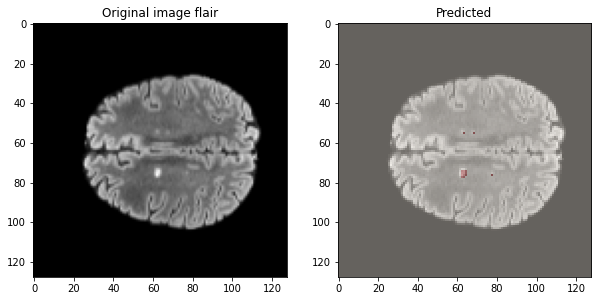

11/11 [==============================] - 40s 4s/step


<Figure size 720x1080 with 0 Axes>

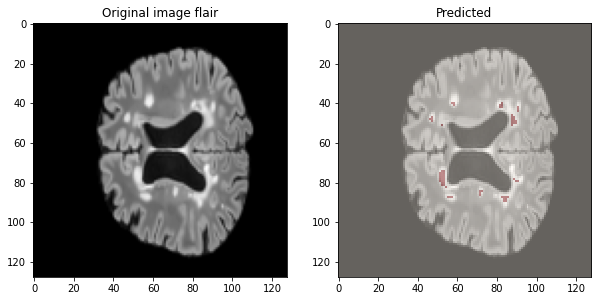

11/11 [==============================] - 38s 3s/step


<Figure size 720x1080 with 0 Axes>

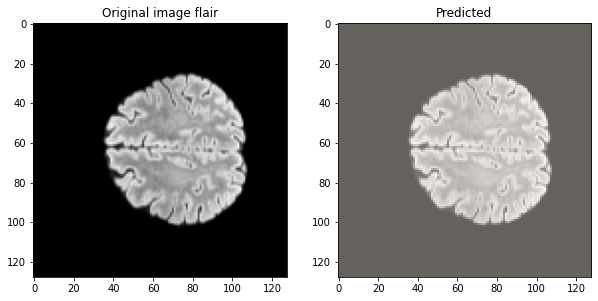

11/11 [==============================] - 36s 3s/step


<Figure size 720x1080 with 0 Axes>

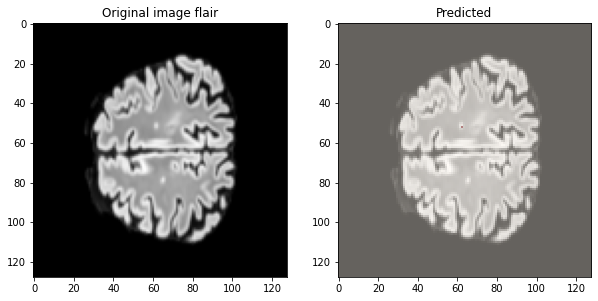

11/11 [==============================] - 37s 3s/step


<Figure size 720x1080 with 0 Axes>

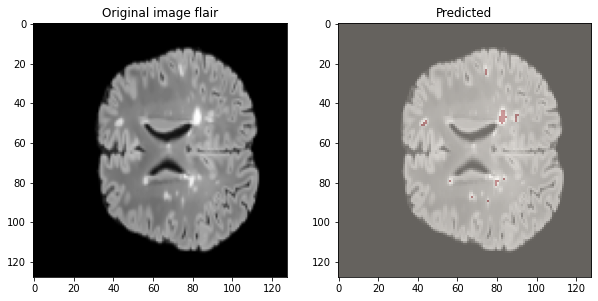

11/11 [==============================] - 39s 4s/step


<Figure size 720x1080 with 0 Axes>

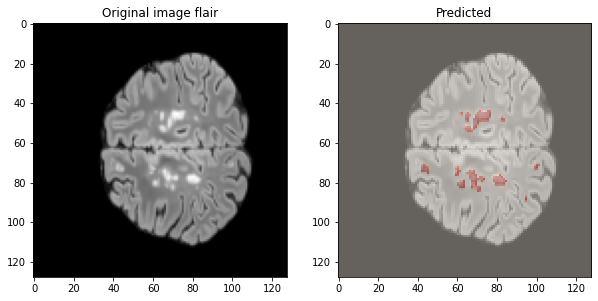

11/11 [==============================] - 35s 3s/step


<Figure size 720x1080 with 0 Axes>

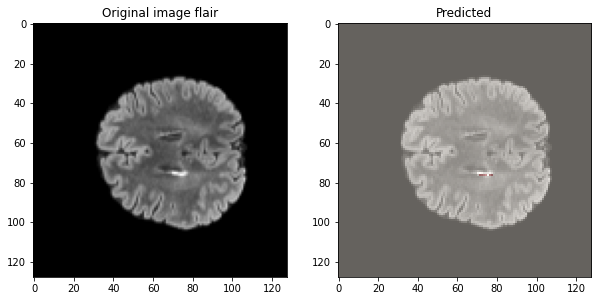

11/11 [==============================] - 39s 4s/step


<Figure size 720x1080 with 0 Axes>

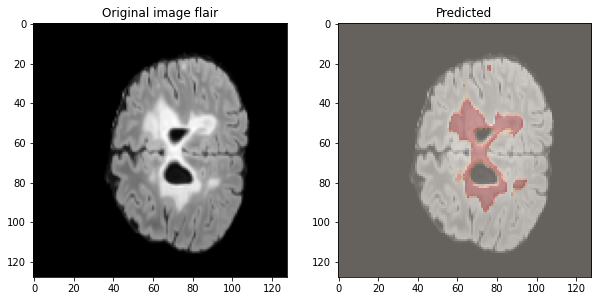

11/11 [==============================] - 38s 3s/step


<Figure size 720x1080 with 0 Axes>

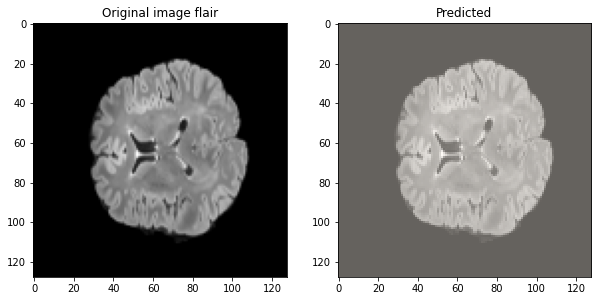

11/11 [==============================] - 36s 3s/step


<Figure size 720x1080 with 0 Axes>

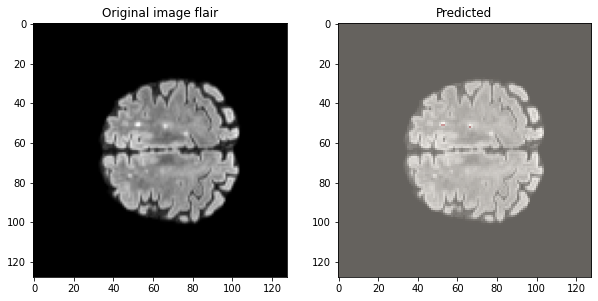

11/11 [==============================] - 38s 3s/step


<Figure size 720x1080 with 0 Axes>

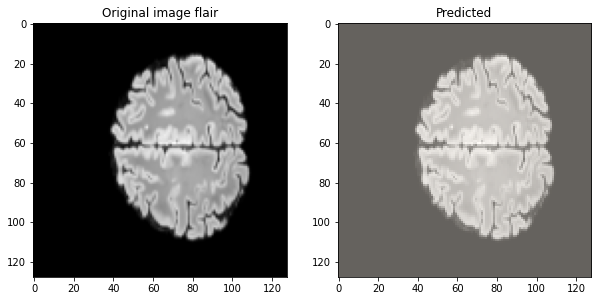

11/11 [==============================] - 35s 3s/step


<Figure size 720x1080 with 0 Axes>

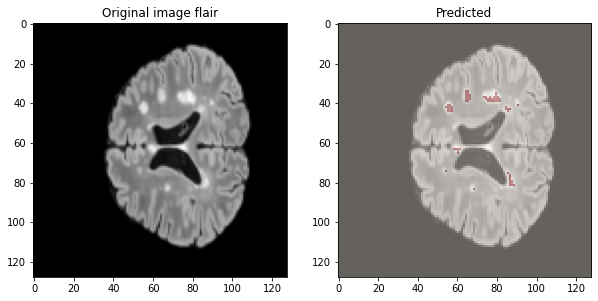

11/11 [==============================] - 36s 3s/step


<Figure size 720x1080 with 0 Axes>

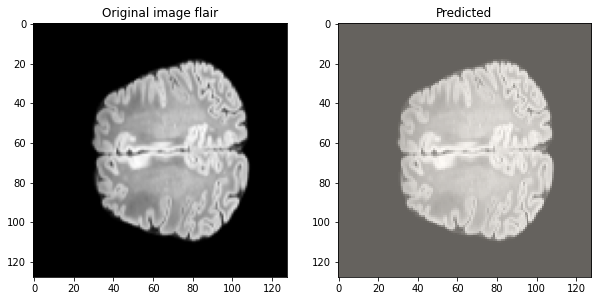

11/11 [==============================] - 36s 3s/step


<Figure size 720x1080 with 0 Axes>

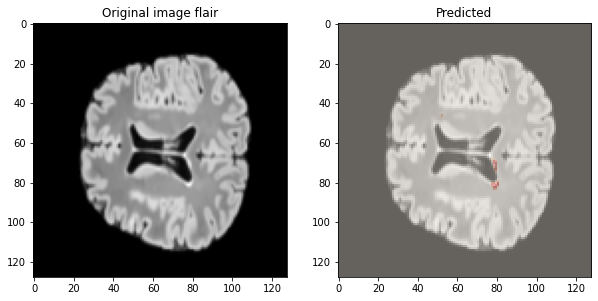

11/11 [==============================] - 37s 3s/step


<Figure size 720x1080 with 0 Axes>

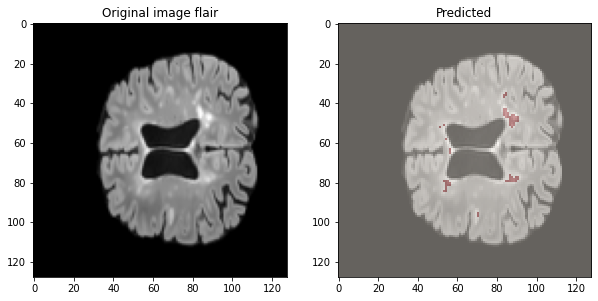

11/11 [==============================] - 36s 3s/step


<Figure size 720x1080 with 0 Axes>

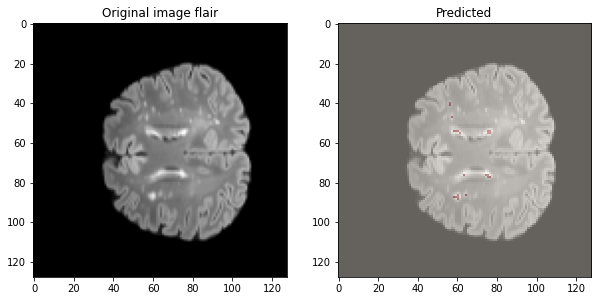

11/11 [==============================] - 40s 4s/step


<Figure size 720x1080 with 0 Axes>

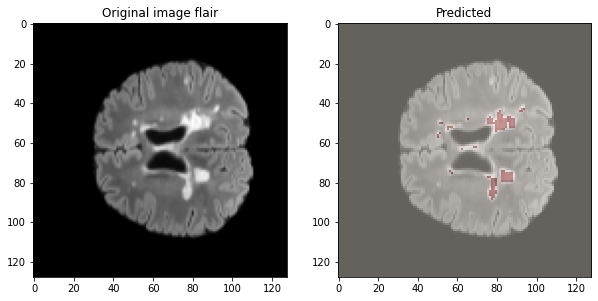

11/11 [==============================] - 38s 3s/step


<Figure size 720x1080 with 0 Axes>

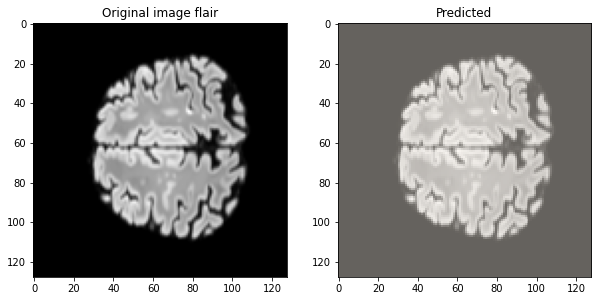

11/11 [==============================] - 39s 4s/step


<Figure size 720x1080 with 0 Axes>

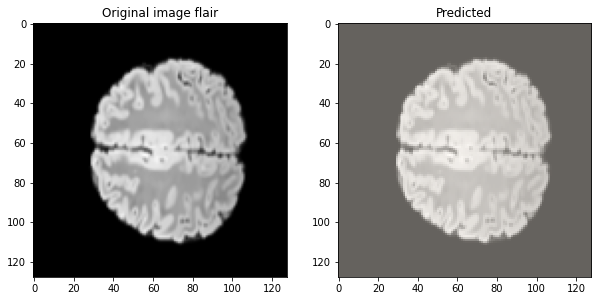

11/11 [==============================] - 39s 3s/step


<Figure size 720x1080 with 0 Axes>

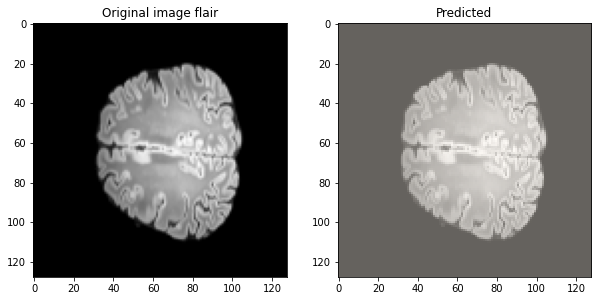

11/11 [==============================] - 39s 3s/step


<Figure size 720x1080 with 0 Axes>

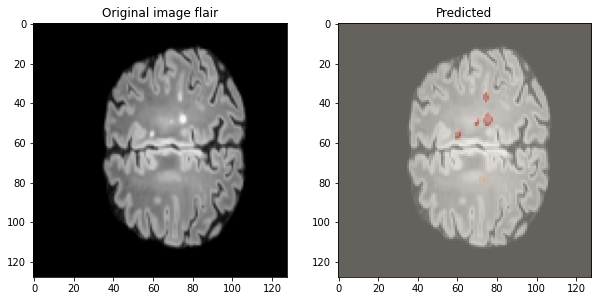

11/11 [==============================] - 38s 3s/step


<Figure size 720x1080 with 0 Axes>

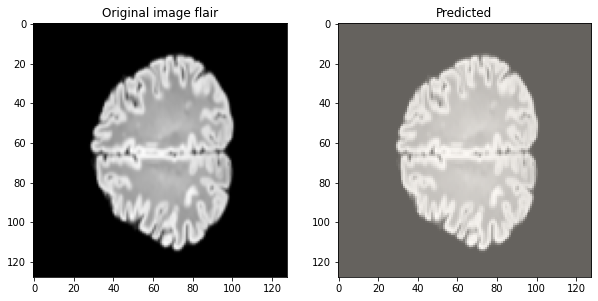

11/11 [==============================] - 38s 3s/step


<Figure size 720x1080 with 0 Axes>

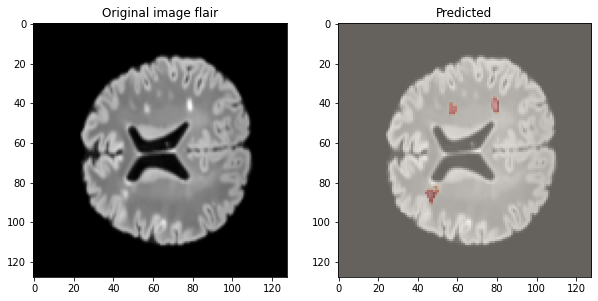

11/11 [==============================] - 41s 4s/step


<Figure size 720x1080 with 0 Axes>

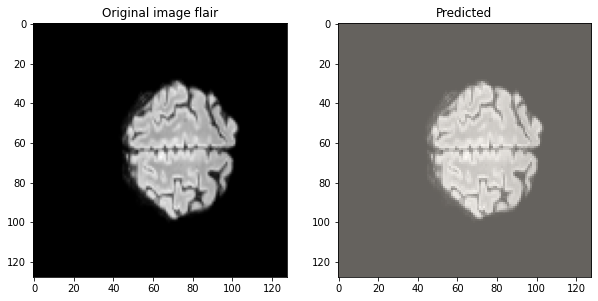

11/11 [==============================] - 42s 4s/step


<Figure size 720x1080 with 0 Axes>

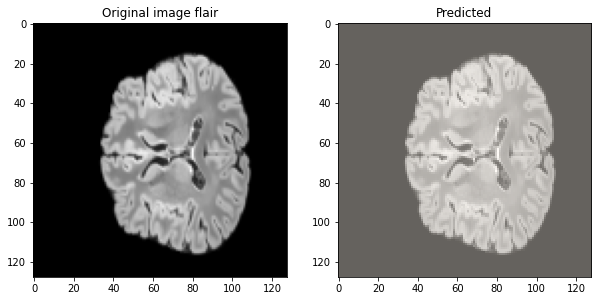

11/11 [==============================] - 40s 4s/step


<Figure size 720x1080 with 0 Axes>

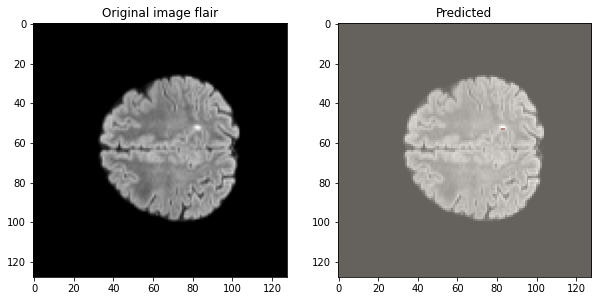

11/11 [==============================] - 42s 4s/step


<Figure size 720x1080 with 0 Axes>

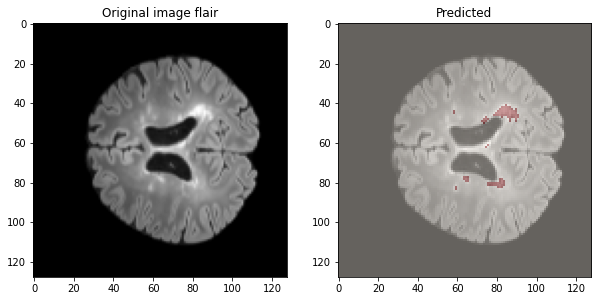

11/11 [==============================] - 39s 4s/step


<Figure size 720x1080 with 0 Axes>

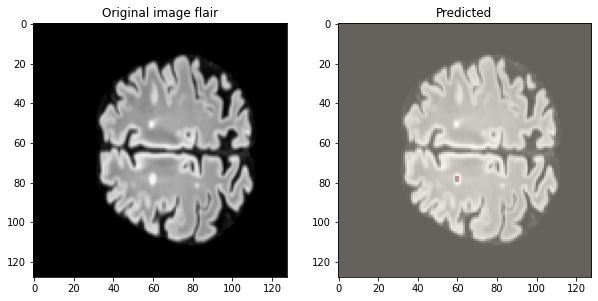

11/11 [==============================] - 41s 4s/step


<Figure size 720x1080 with 0 Axes>

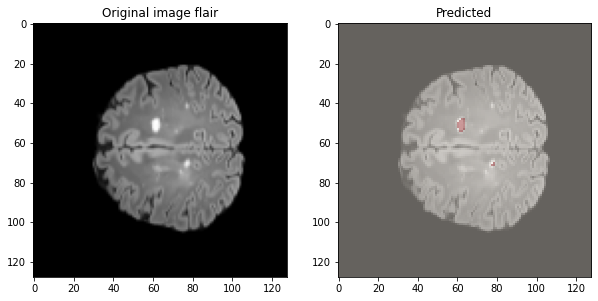

11/11 [==============================] - 43s 4s/step


<Figure size 720x1080 with 0 Axes>

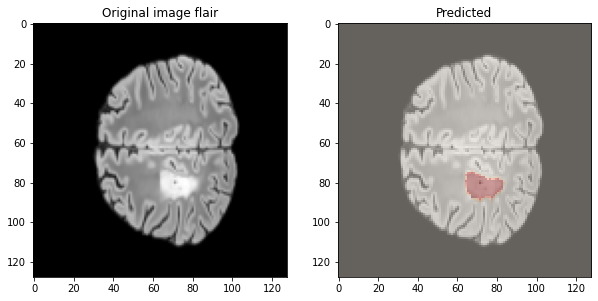

11/11 [==============================] - 41s 4s/step


<Figure size 720x1080 with 0 Axes>

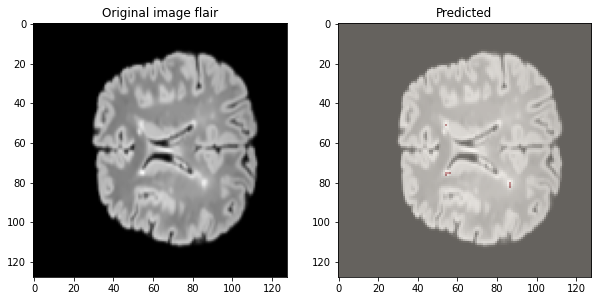

11/11 [==============================] - 41s 4s/step


<Figure size 720x1080 with 0 Axes>

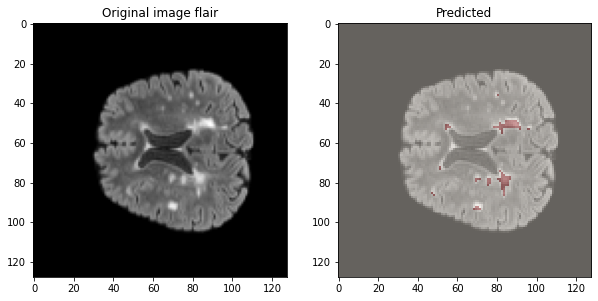

11/11 [==============================] - 45s 4s/step


<Figure size 720x1080 with 0 Axes>

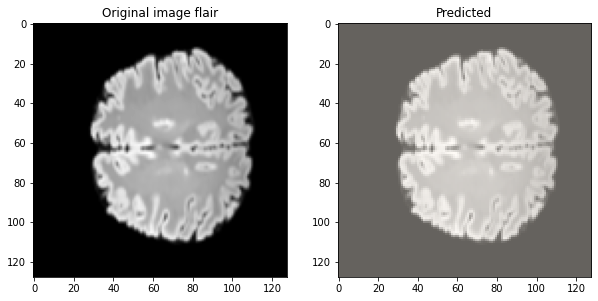

11/11 [==============================] - 41s 4s/step


<Figure size 720x1080 with 0 Axes>

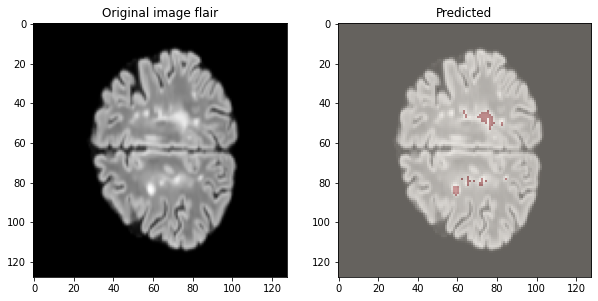

11/11 [==============================] - 35s 3s/step


<Figure size 720x1080 with 0 Axes>

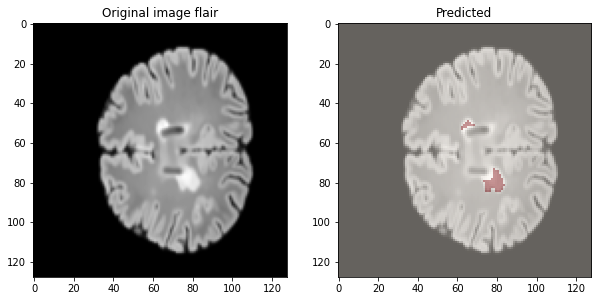

11/11 [==============================] - 34s 3s/step


<Figure size 720x1080 with 0 Axes>

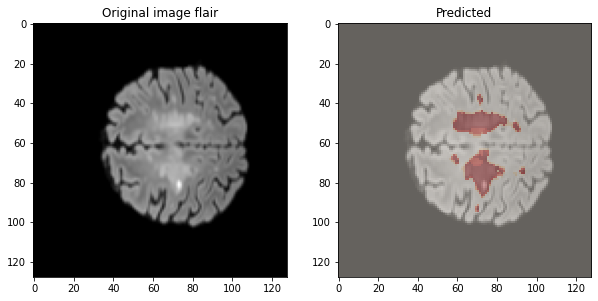

11/11 [==============================] - 29s 3s/step


<Figure size 720x1080 with 0 Axes>

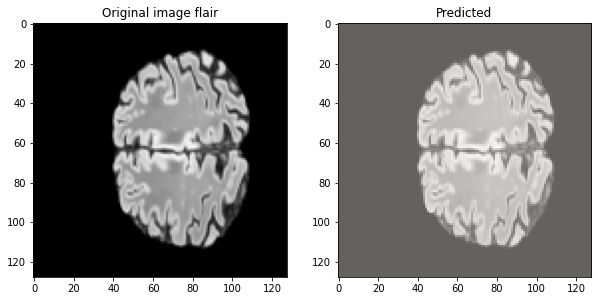

In [30]:
VOLUME_START_AT=60
VOLUME_SLICES=350


def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 

        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, f'MSSEG2016_TrainingData_Patient{case}_FLAIR_preprocessed.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'MSSEG2016_TrainingData_Patient{case}_DP_preprocessed.nii');
    ce=nib.load(vol_path).get_fdata() 
    


    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

        
    return model1.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 300):
    path = f"D:/Projects/39111/Second_update/MSSEG2016_TrainingData/MSSEG2016_TrainingData_Patient{case}"
    gt = nib.load(os.path.join(path, f'MSSEG2016_TrainingData_Patient{case}_Consensus.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'MSSEG2016_TrainingData_Patient{case}_FLAIR_preprocessed.nii')).get_fdata()
    p = predictByPath(path,case)
    


    plt.figure(figsize=(10, 15))
    f, axarr = plt.subplots(1,2, figsize = (10, 15)) 

    for i in range(2): 
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    
    predicted=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    axarr[1].imshow(predicted,cmap='OrRd', interpolation='none', alpha=0.4) 
    axarr[1].title.set_text('Predicted')

    
    plt.show()

    
showPredictsById(case=val_ids[0][-3:])
showPredictsById(case=val_ids[1][-3:])
showPredictsById(case=val_ids[2][-3:])  
showPredictsById(case=val_ids[3][-3:])
showPredictsById(case=val_ids[4][-3:])
showPredictsById(case=val_ids[5][-3:])
showPredictsById(case=val_ids[8][-3:])
showPredictsById(case=val_ids[6][-3:])

showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[6][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[1][-3:])

showPredictsById(case=train_ids[2][-3:])
showPredictsById(case=train_ids[3][-3:])
showPredictsById(case=train_ids[5][-3:])
showPredictsById(case=train_ids[6][-3:])
showPredictsById(case=train_ids[9][-3:])
showPredictsById(case=train_ids[10][-3:])
showPredictsById(case=train_ids[12][-3:])
showPredictsById(case=train_ids[13][-3:])
showPredictsById(case=train_ids[18][-3:])
showPredictsById(case=train_ids[20][-3:])
showPredictsById(case=train_ids[34][-3:])
showPredictsById(case=train_ids[30][-3:])
showPredictsById(case=train_ids[27][-3:])
showPredictsById(case=train_ids[25][-3:])
showPredictsById(case=train_ids[24][-3:])
showPredictsById(case=train_ids[22][-3:])
showPredictsById(case=train_ids[21][-3:])
showPredictsById(case=train_ids[19][-3:])
showPredictsById(case=train_ids[17][-3:])
showPredictsById(case=train_ids[16][-3:])
showPredictsById(case=train_ids[15][-3:])
showPredictsById(case=train_ids[14][-3:])
showPredictsById(case=train_ids[11][-3:])
showPredictsById(case=train_ids[8][-3:])
showPredictsById(case=train_ids[7][-3:])
showPredictsById(case=train_ids[4][-3:])
showPredictsById(case=train_ids[1][-3:])
   
    



# Model Comparison

<built-in method keys of dict object at 0x0000021A80BBCE40>
['Existing Accuracy_Unet ', 'Existing Accuracy_resnet', 'Existing Accuracy_inceptionv3', 'Proposed Accuracy dualvnet ']


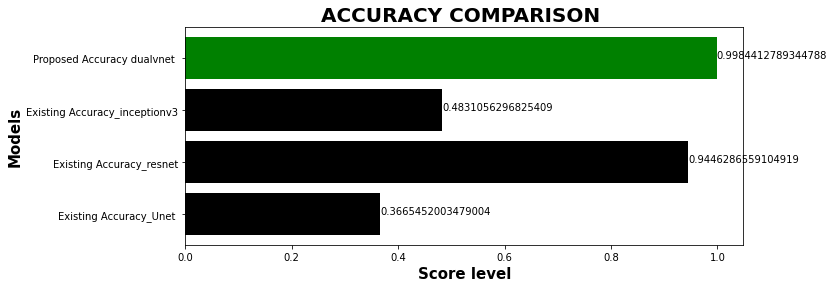

In [31]:
data = {'Existing Accuracy_Unet ':U_net[1],'Existing Accuracy_resnet':resnet[1], 'Existing Accuracy_inceptionv3':inceptionv3[1],'Proposed Accuracy dualvnet ':dualvnet[1]}

print(data.keys)
label = list(data.keys())
print(label)
model = list(data.values())
color = ['black','black','black','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color )

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("ACCURACY COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

<built-in method keys of dict object at 0x0000021ACD603000>
['Existing loss_Unet ', 'Existing loss_resnet', 'Existing loss_inceptionv3', 'Proposed loss_dualvnet ']


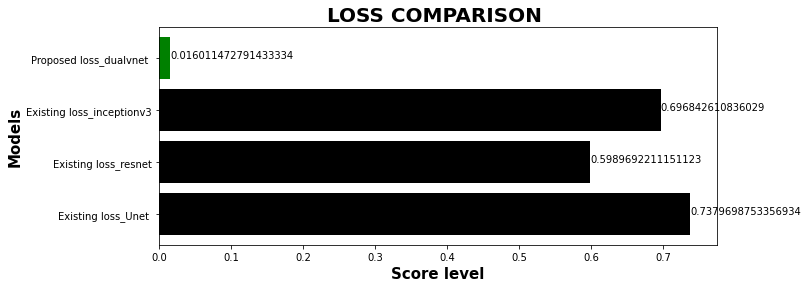

In [32]:
data = {'Existing loss_Unet ':U_net[0],'Existing loss_resnet':resnet[0], 'Existing loss_inceptionv3':inceptionv3[0],'Proposed loss_dualvnet ':dualvnet[0]}

print(data.keys)
label = list(data.keys())
print(label)
model = list(data.values())
color = ['black','black','black','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color )

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("LOSS COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

<built-in method keys of dict object at 0x0000021ACCB35040>
['Existing IOU_Unet ', 'Existing IOU_resnet', 'Existing IOU_inceptionv3', 'Proposed IOU_dualvnet ']


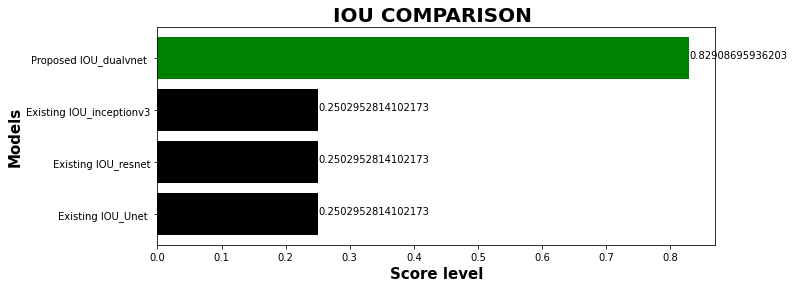

In [33]:
data = {'Existing IOU_Unet ':U_net[2],'Existing IOU_resnet':resnet[2], 'Existing IOU_inceptionv3':inceptionv3[2],'Proposed IOU_dualvnet ':dualvnet[2]}

print(data.keys)
label = list(data.keys())
print(label)
model = list(data.values())
color = ['black','black','black','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color )

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("IOU COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

<built-in method keys of dict object at 0x0000021A80BD2380>
['Existing precision_Unet ', 'Existing precision_resnet', 'Existing precision_inceptionv3', 'Proposed precision_dualvnet']


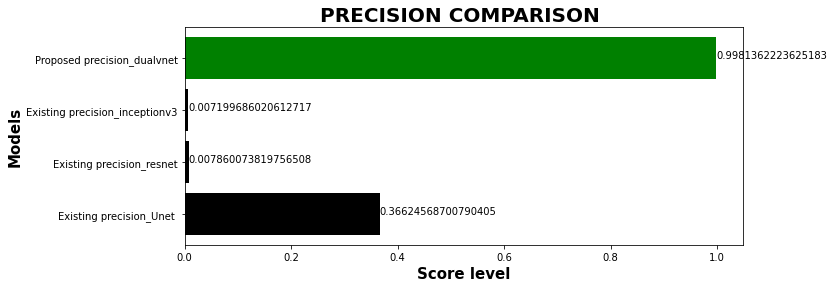

In [34]:
data = {'Existing precision_Unet ':U_net[4],'Existing precision_resnet':resnet[4], 'Existing precision_inceptionv3':inceptionv3[4],'Proposed precision_dualvnet':dualvnet[4]}

print(data.keys)
label = list(data.keys())
print(label)
model = list(data.values())
color = ['black','black','black','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color )

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("PRECISION COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

<built-in method keys of dict object at 0x0000021A82FC4580>
['Existing sensitivity_Unet ', 'Existing sensitivity_resnet', 'Existing sensitivity inceptionv3', 'Proposed sensitivity dualvnet ']


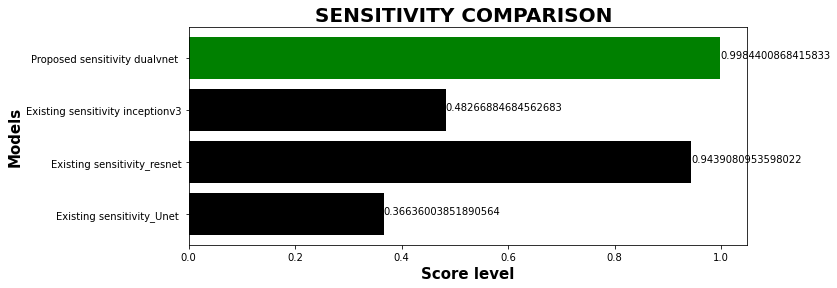

In [35]:
data = {'Existing sensitivity_Unet ':U_net[5],'Existing sensitivity_resnet':resnet[5], 'Existing sensitivity inceptionv3':inceptionv3[5],'Proposed sensitivity dualvnet ':dualvnet[5]}

print(data.keys)
label = list(data.keys())
print(label)
model = list(data.values())
color = ['black','black','black','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color )

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("SENSITIVITY COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

<built-in method keys of dict object at 0x0000021ACD591E40>
['Existing specificity_Unet ', 'Existing specificity_resnet', 'Existing specificity inceptionv3', 'Proposed specificity dualvnet']


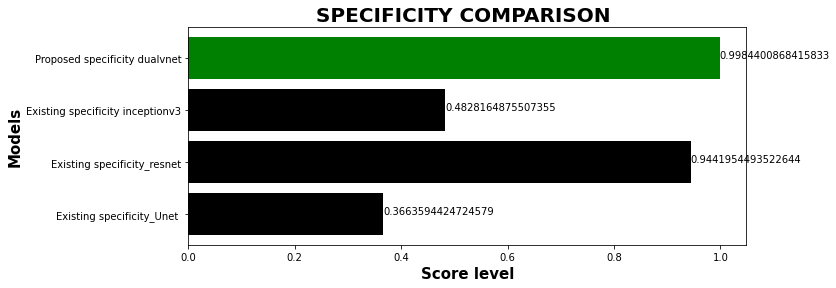

In [36]:
data = {'Existing specificity_Unet ':U_net[6],'Existing specificity_resnet':resnet[6], 'Existing specificity inceptionv3':inceptionv3[6],'Proposed specificity dualvnet':dualvnet[6]}

print(data.keys)
label = list(data.keys())
print(label)
model = list(data.values())
color = ['black','black','black','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color )

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("SPECIFICITY COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()